In [249]:
! pip install textblob_fr
! pip install transformers
! pip install stop_words
! pip install vaderSentiment_fr
!pip install gensim

     |████████████████████████████████| 3.4 MB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 4.6 MB/s eta 0:00:01


In [250]:
%autosave 60
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from matplotlib import cm
from sklearn.preprocessing import OneHotEncoder
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())


# Core packages for text processing.
import string
import re

# Libraries for text preprocessing.
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords


# Utility
import logging
import itertools

# Core packages for general use throughout the notebook.
import random
import warnings
import time
import datetime

# For customizing our plots.
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches



Autosaving every 60 seconds


In [251]:
# Loading some sklearn packaces for modelling.
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # not actively using
from sklearn.decomposition import LatentDirichletAllocation, NMF # not actively using
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split


In [252]:
# for build our model
#import tensorflow as tf

#from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.optimizers import Adam
#from transformers import BertTokenizer, TFBertModel

In [253]:
data=pd.read_csv('avisassurance_train.csv',sep=';')
datatest=pd.read_csv('avisassurance_test.csv',sep=';')

# Data description


In [254]:
data

date  note  \
0                                           06 septem...     5   
1                                           03 mai 20...     4   
2                                           21 mars 2...     5   
3                                           10 juin 2...     4   
4                                           29 janvie...     1   
...                                                  ...   ...   
24100                                       22 mars 2...     1   
24101                                       06 décemb...     1   
24102                                       14 avril ...     1   
24103                                       11 juille...     3   
24104                                       19 janvie...     1   

                  auteur                                               avis  \
0       brahim--k-131532  Meilleurs assurances, prix, solutions, écoute,...   
1       bernard-g-112497  je suis globalement satisfait , sauf que vous ...   
2      virginie-t-107352  Prix tres abordable plusieurs options s'offren...   
3       boulain-f-116580  je satisfait du service, une réponse très rapi...   
4        ouaille31-51798  Client depuis plus de 25 ans, très déçu de cet...   
...                  ...                                                ...   
24100      hophop-107522  Assurance moto chez la mutuel des motards en F...   
24101          tzl-81680  Même les demandes les plus simples n'aboutisse...   
24102   jmr-72500-110395  En décembre 2019, j'ai souscrit à un contrat C...   
24103         cris-77532  Je suis assurer à la gmf depuis plus de 15 ans...   
24104        jesse-51459  Bonjour\r\nMon ami vient de se faire voler sa ...   

                   assureur     produit  
0          Direct Assurance        auto  
1          Direct Assurance        auto  
2          Direct Assurance        auto  
3       L'olivier Assurance        auto  
4                    Matmut        auto  
...                     ...         ...  
24100  Mutuelle des Motards        moto  
24101               Allianz  habitation  
24102     Cegema Assurances       sante  
24103                   GMF        auto  
24104                   AMV        moto  

[24105 rows x 6 columns]

In [264]:
data.dtypes.unique()

array([dtype('O'), dtype('int64')], dtype=object)

In [265]:
datatest.describe(include="all").T

count unique                                                top  \
date      10332   1732                                       01 septem...   
auteur    10332  10238                                        smt75-64040   
avis      10331  10322  Intervention supprimée à la demande de l'inter...   
assureur  10332     56                                   Direct Assurance   
produit   10332     13                                               auto   

          freq  
date        48  
auteur       3  
avis         6  
assureur  2607  
produit   6082

In [266]:
data.produit.value_counts()

auto                                     14077
sante                                     3525
moto                                      2105
habitation                                1956
prevoyance                                 791
credit                                     653
vie                                        578
animaux                                    374
multirisque-professionnelle                 20
garantie-decennale                          12
assurances-professionnelles                  8
responsabilite-civile-professionnelle        5
flotte-automobile                            1
Name: produit, dtype: int64

In [267]:
data["avis"] = data["avis"].fillna('None')
datatest["avis"] = datatest["avis"].fillna('None')
data["auteur"] = data["auteur"].fillna('None')

On souhaite prédire la variable **Note**. <p>

Pour cela, on dispose du jeu de données data qui contient 24105 observations et 5 variables qui sont toute qualitatives :


*   **date** : il contient la date de publication de l'examen et la période d'expérience de l'examen, et il doit être nettoyé.
*   **auteur** : l'identifiant du client
*   **avis** : le texte avec l'avis
*   **assureur** : le nom de l'assurance
*   **produit** : le type d'assurance


La première étape est de créer un modèle non supervisé pour mieux comprendre les critiques et créer des segmentations qu'on pourra interpréter. Ensuite, il faudra différents modèles pour prédire le nombre d'étoiles d'une critique à l'aide de l'ensemble de données d'entraînement..<p>

# Data Vizualisation

In [268]:
data

date  note  \
0                                           06 septem...     5   
1                                           03 mai 20...     4   
2                                           21 mars 2...     5   
3                                           10 juin 2...     4   
4                                           29 janvie...     1   
...                                                  ...   ...   
24100                                       22 mars 2...     1   
24101                                       06 décemb...     1   
24102                                       14 avril ...     1   
24103                                       11 juille...     3   
24104                                       19 janvie...     1   

                  auteur                                               avis  \
0       brahim--k-131532  Meilleurs assurances, prix, solutions, écoute,...   
1       bernard-g-112497  je suis globalement satisfait , sauf que vous ...   
2      virginie-t-107352  Prix tres abordable plusieurs options s'offren...   
3       boulain-f-116580  je satisfait du service, une réponse très rapi...   
4        ouaille31-51798  Client depuis plus de 25 ans, très déçu de cet...   
...                  ...                                                ...   
24100      hophop-107522  Assurance moto chez la mutuel des motards en F...   
24101          tzl-81680  Même les demandes les plus simples n'aboutisse...   
24102   jmr-72500-110395  En décembre 2019, j'ai souscrit à un contrat C...   
24103         cris-77532  Je suis assurer à la gmf depuis plus de 15 ans...   
24104        jesse-51459  Bonjour\r\nMon ami vient de se faire voler sa ...   

                   assureur     produit  
0          Direct Assurance        auto  
1          Direct Assurance        auto  
2          Direct Assurance        auto  
3       L'olivier Assurance        auto  
4                    Matmut        auto  
...                     ...         ...  
24100  Mutuelle des Motards        moto  
24101               Allianz  habitation  
24102     Cegema Assurances       sante  
24103                   GMF        auto  
24104                   AMV        moto  

[24105 rows x 6 columns]

### Nombre de commentaire par assurance

In [269]:
Assureur=data.groupby('assureur')['assureur'].agg(['count'])
Assureur=pd.DataFrame(Assureur).sort_values(by ='count',ascending=False)
Assureur['Assurance']=Assureur.index
#Assureur.count

In [270]:
import plotly.express as px
fig =px.bar(Assureur.head(10), x='Assurance', y='count',color="Assurance")
#px.histogram(data, x="assureur",color="assureur")
fig.update_layout(
    title_text='Top 10 des assurances avec le plus de nombre de commentaires', # title of plot
    xaxis_title_text='Assurance', # xaxis label
    yaxis_title_text='Nombre de Commentaires', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
fig.show()

### Nombre de commentaire par type de produit

In [271]:
fig = px.histogram(data, x="produit",color="produit")
fig.update_layout(
    title_text='Nombre de Commentaires par produit', # title of plot
    xaxis_title_text='Assurance', # xaxis label
    yaxis_title_text='Nombre de Commentaires', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
fig.show()

### Nombre de commentaire en fonction du temps

On va créer de nouvelle colonnes avec les données temporelles qui pourront être expoloiter. <p>

Pour cela, on va séparer la colonne date grâce au word tokenizer et ainsi créer les colonnes suivantes :


*   **jour** : il indique le jour de la publication du commentaire
*   **mois** : il indique le mois de la publication du commentaire
*   **année** : il indique l'année de la publication du commentaire
*   **mois_siniste** : il indique le mois où est apparu le sinistre
*   **annee_siniste** : il indique l'année où est apparu le sinistre

<p>

In [272]:
jour=[]
mois=[]
annee=[]
mois_siniste=[]
annee_siniste=[]

for i in data.date:
    content_french = (i)
    temp=word_tokenize(content_french, language='french')
    jour.append(temp[0])
    mois.append(temp[1])
    annee.append(temp[2])
    mois_siniste.append(temp[8])
    annee_siniste.append(temp[9])
    
    
data['Jour']=jour
data['Mois']=mois
data['Annee']=annee
data['mois_siniste']=mois_siniste
data['annee_siniste']=annee_siniste

In [273]:
#test

jour=[]
mois=[]
annee=[]
mois_siniste=[]
annee_siniste=[]

for i in datatest.date:
    content_french = (i)
    temp=word_tokenize(content_french, language='french')
    jour.append(temp[0])
    mois.append(temp[1])
    annee.append(temp[2])
    mois_siniste.append(temp[8])
    annee_siniste.append(temp[9])
    
datatest['Jour']=jour
datatest['Mois']=mois
datatest['Annee']=annee
datatest['mois_siniste']=mois_siniste
datatest['annee_siniste']=annee_siniste

In [274]:
data=data.drop('date',axis=1)
datatest=datatest.drop('date',axis=1)

In [275]:
annee=pd.DataFrame(data.Annee).sort_values(by =  'Annee')
fig = px.histogram(annee, x="Annee",color="Annee")
fig.update_layout(
    title_text='Nombre de commentaires par année', # title of plot
    xaxis_title_text='Année', # xaxis label
    yaxis_title_text='Nombre de commentaires', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
fig.show()

In [276]:
import plotly.express as px
fig = px.pie(data, values='Annee', names='Annee', title='Nombre de commentaires par année',)
fig.show()

In [277]:
dico={"janvier": 1, "février": 2,
      "mars": 3, "avril": 4,
      "mai": 5, "juin": 6,
      "juillet": 7, "août": 8,
      "septembre": 9, "octobre": 10,
      "novembre":11,"décembre":12}


data["Mois"]=data["Mois"].apply(lambda x: dico[x])
data["Jour"]=data["Jour"].apply(lambda x: int(x))
data["Annee"]=data["Annee"].apply(lambda x: int(x))
data["mois_siniste"]=data["mois_siniste"].apply(lambda x: dico[x])
data["annee_siniste"]=data["annee_siniste"].apply(lambda x: int(x))





In [278]:
###test 
datatest["Mois"]=datatest["Mois"].apply(lambda x: dico[x])
datatest["Jour"]=datatest["Jour"].apply(lambda x: int(x))
datatest["Annee"]=datatest["Annee"].apply(lambda x: int(x))
datatest["mois_siniste"]=datatest["mois_siniste"].apply(lambda x: dico[x])
datatest["annee_siniste"]=datatest["annee_siniste"].apply(lambda x: int(x))


In [279]:
Mois=pd.DataFrame(data.Mois).sort_values(by =  'Mois')
countMois=Mois.groupby('Mois')['Mois'].agg(['count'])
Mois=pd.merge(Mois, countMois, on='Mois')
Mois=Mois.sort_values(by =  'count')


In [280]:
fig = px.histogram(Mois, x="Mois",color="Mois")
fig.update_layout(
    title_text='Nombre de commentaires par mois', 
    xaxis_title_text='Mois', 
    yaxis_title_text='Nombre de commentaires', 
    bargap=0.2, 
    bargroupgap=0.1
)
fig.show()

### Nombre de commentaire en fonction des notes

In [281]:
fig = px.histogram(data, x="note",color="note")
fig.update_layout(
    title_text='Nombre de commentaire en fonction des notes attribuées', 
    xaxis_title_text='Notes attribuées', 
    yaxis_title_text='Nombre de commentaire', 
    bargap=0.2, 
    bargroupgap=0.1
)
fig.show()

### Note moyenne par assurance

In [282]:
MeanAssureur=data.groupby('assureur').mean()['note']
MeanAssureur=pd.DataFrame(MeanAssureur).sort_values(by = 'note',ascending=False)
MeanAssureur['Assurance']=MeanAssureur.index


In [283]:
import plotly.express as px
fig = px.bar(MeanAssureur.head(20), x="Assurance",y='note',color="Assurance")
fig.update_layout(
    title_text='Nombre de Commentaires par Assurance', # title of plot
    xaxis_title_text='Assurance', # xaxis label
    yaxis_title_text='Nombre de Commentaires', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
fig.show()

# Data Cleaning

#### Supprimer les mots parasites

In [284]:
data["avis"]= data["avis"].str.lower()
datatest["avis"]= datatest["avis"].str.lower()

In [285]:
def clean_text(text):
    text = re.sub(r'@ [A-Za-z0-9]+','',text) #Removed mentions
    text = re.sub(r'#','',text) #remove the #symbol
    text = re.sub(r'RT[\s]+' , '' , text) # remove RT
    text = re.sub(r'https?:\/\/\S+' , '' , text) #Removed hyperlink
    text = "" .join([ch for ch in text if ch not in string.punctuation]) #Remove punctuation
    text = text.replace("  " , " ")
    text = " ".join([x for x in text.split(" ") if not x.isdigit()]) # Removed Numbers
    text = text.lower() # lower text
    return text

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


data['avis'] = data['avis'].apply(lambda x: remove_URL(x))
data['avis'] = data['avis'].apply(lambda x: remove_html(x))
data['avis'] = data['avis'].apply(lambda x: remove_punct(x))
data['avis'] = data['avis'].apply(lambda x: clean_text(x))

datatest['avis'] = datatest['avis'].apply(lambda x: remove_URL(x))
datatest['avis'] = datatest['avis'].apply(lambda x: remove_html(x))
datatest['avis'] = datatest['avis'].apply(lambda x: remove_punct(x))
datatest['avis'] = datatest['avis'].apply(lambda x: clean_text(x))

In [286]:
data.head()

note             auteur                                               avis  \
0     5   brahim--k-131532  meilleurs assurances prix solutions écoute rap...   
1     4   bernard-g-112497  je suis globalement satisfait sauf que vous av...   
2     5  virginie-t-107352  prix tres abordable plusieurs options soffrent...   
3     4   boulain-f-116580  je satisfait du service une réponse très rapid...   
4     1    ouaille31-51798  client depuis plus de ans très déçu de cette m...   

              assureur produit  Jour  Mois  Annee  mois_siniste  annee_siniste  
0     Direct Assurance    auto     6     9   2021             9           2021  
1     Direct Assurance    auto     3     5   2021             5           2021  
2     Direct Assurance    auto    21     3   2021             3           2021  
3  L'olivier Assurance    auto    10     6   2021             6           2021  
4               Matmut    auto    29     1   2017             1           2017

In [287]:
#SUPPRIMER LES STOPWORD
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')
from stop_words import get_stop_words

final_stopwords_list =  stopwords.words('french')

stopwordss = get_stop_words('fr')

stopwordsperso = set(["ai","avais","a","as","avons","est","etait","ete","la","j","d","l",
"peu","en","ce","au","vu","faire","pour","une","nan","de","et","nous","que","si","le",
"il","ma","vous","y","c","des","on","un","les","je","ne","pas","ces","m","qu","fallut",
"ou","sur","du","fais","me","fait","fur","mais","cela","pr","avait","mis","plus","tous",
"part","sinon","tout","sont","sans","an","qui","cest","cas","par","memes","meme","sous",
"aurais","malgre","etaient","vraiment","donc","votre","plutot","passe","n","avoir","aussi",
"chose","assez","trop","moins","mieux","beaucoup","grace","cette","vrai","voir","choses",
"trouve","journee","appris","pense","bien","bonjour","cette",'cela',"j'ai","a","ai","c'est",
'an','faire','fait','si',"qu'il","m'a",'aa','aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaje',
 'aaaaaah','aah','aan','jai','ùoins'])

final_stopwords_list.extend(stopwordsperso)
final_stopwords_list.extend(stopwordss)

deselect_stop_words = ['n\'', 'ne','pas','plus','personne','aucun','ni','aucune','rien']
for w in deselect_stop_words:
    if w in final_stopwords_list:
        final_stopwords_list.remove(w)
    else:
        continue

In [288]:
import re
AComment=[]
for comment in data["avis"].apply(str):
    Word_Tok = []
    for word in  re.sub("\W"," ",comment ).split():
        Word_Tok.append(word)
    AComment.append(Word_Tok)
    
data["Word_Tok"]= AComment


#test
ACommenttest=[]
for comment in datatest["avis"].apply(str):
    Word_Tok = []
    for word in  re.sub("\W"," ",comment ).split():
        Word_Tok.append(word)
    ACommenttest.append(Word_Tok)
    
datatest["Word_Tok"]= ACommenttest

In [289]:
AllfilteredComment=[]
for comment in data["Word_Tok"]:
    filteredComment = [w for w in comment if not ((w in final_stopwords_list) or (len(w) == 1) or w=='jai' or (len(w) >= 10) or w.isdigit())]
    AllfilteredComment.append(' '.join(filteredComment))
    
data["Comment"]=AllfilteredComment



#test
AllfilteredCommenttest=[]
for comment in datatest["Word_Tok"]:
    filteredComment = [w for w in comment if not ((w in final_stopwords_list) or (len(w) == 1) or w=='jai' or (len(w) >= 10) or w.isdigit() )]
    AllfilteredCommenttest.append(' '.join(filteredComment))
    
datatest["Comment"]=AllfilteredCommenttest


In [290]:
def tokenizer(text):
    result = re.split('\W+' , text)
    return result


data['avis_tok'] = data['Comment'].apply(lambda x: tokenizer(x))
data['avis_tok'] = data['avis_tok'].apply(', '.join)
data['avis_tok'] = data['avis_tok'].apply(lambda x : x.split())


#test
datatest['avis_tok'] = datatest['Comment'].apply(lambda x: tokenizer(x))
datatest['avis_tok'] = datatest['avis_tok'].apply(', '.join)
datatest['avis_tok'] = datatest['avis_tok'].apply(lambda x : x.split())

In [291]:
avisAssurance=data[['assureur','Comment']].groupby('assureur').sum()['Comment']
avisAssurance=pd.DataFrame(avisAssurance).sort_values(by = 'Comment',ascending=False)
avisAssurance['Assurance']=avisAssurance.index
#avisAssurance.loc[:,'avis']
avisAssurance=pd.merge(Assureur, avisAssurance, on='Assurance')
avisAssurance

count             Assurance  \
0    5896      Direct Assurance   
1    4288   L'olivier Assurance   
2    1023            APRIL Moto   
3     998                   GMF   
4     861        Néoliane Santé   
5     829                 MACIF   
6     688                   AMV   
7     658              Santiane   
8     629                   AXA   
9     612                  MAAF   
10    591                  MAIF   
11    574               Allianz   
12    553              Pacifica   
13    474                Matmut   
14    446                   MGP   
15    403     Active Assurances   
16    350      Ag2r La Mondiale   
17    312     Harmonie Mutuelle   
18    289               Eurofil   
19    283                 APRIL   
20    267                Mercer   
21    265                Cardif   
22    245                Zen'Up   
23    214     Cegema Assurances   
24    212            Génération   
25    209                  Mgen   
26    147        CNP Assurances   
27    146         Crédit Mutuel   
28    144                  Afer   
29    138             SwissLife   
30    132        Eca Assurances   
31    128              Generali   
32    128  Mutuelle des Motards   
33    110          Assur O'Poil   
34     97              Groupama   
35     96              Sogessur   
36     96              SantéVet   
37     72               Sogecap   
38     63             Intériale   
39     53               MetLife   
40     51        Assur Bon Plan   
41     43        Euro-Assurance   
42     38      Malakoff Humanis   
43     33                   Gan   
44     32                 Carac   
45     28     Peyrac Assurances   
46     27             Suravenir   
47     26              Afi Esca   
48     25            Solly Azar   
49     25           AssurOnline   
50     19              Magnolia   
51     18                   LCL   
52     10                  Mapa   
53      6                   Sma   
54      4                   MMA   
55      1                Hiscox   

                                              Comment  
0   meilleurs prix solutions écoute rapidité compa...  
1   satisfait service réponse rapide service remer...  
2   fort pouvoir dune certaine souplesse tarifs pr...  
3   satisfait davoir prix chers payer piur paye la...  
4   vente forcée téléphone graves proches connaîtr...  
5   train dacheter scooter demande prouvant condui...  
6   satisfait assuré longtemps chez amv tarifs cor...  
7   remercie widad amabilité répondre demandes faç...  
8   résilier envoyer copie carte grise selon lai e...  
9   belles promesses réalité menteurs sinistre voi...  
10  assurée maif ans aucuns déchanté suite acciden...  
11  honte totale toutes allianz traitent menaçons ...  
12  surtout souscrire chez assuré chez ans maison ...  
13  client plus ans déçu mutuelle na plus rien dun...  
14  montant payer foyer contrat adapté membres fam...  
15  sinistre durant temps chez active assurance su...  
16  bientôt mois attend mails suite téléphoné dise...  
17  fuir résilie retard paiement comprend somme qu...  
18  attention payez finalisé ensuite modalités ind...  
19  client satisfait prix services donnerai plus d...  
20  peux rejoindre nombreux avis négatifs regrette...  
21  permets poster cardif suite cancer sein mise c...  
22  prix proposer ecoute reste plus croiser doigts...  
23  prend compte après donner accord lagent généra...  
24  jétais chez cocoon janvier dun contrat séjour ...  
25  cher service client fiable plus mois prendre c...  
26  aucun conseil aucune demande dossiers arrêt fi...  
27  payer payer reste chercher petite bête après a...  
28  adhérent afer plus ans regrette choix lafer id...  
29  mai bats prendre charge verres monture swissli...  
30  assurance sérieuse contracté contrat démarre j...  
31  generali vie mauvais service client sérieux ma...  
32  décembre jour accident parisien moto désormais...  
33  manque clarté dont chie partie maladie dépense...  
34  groupama nest cher problème laissent crevé é

#### Récupérer la fréquence de chaque mot

In [292]:
import re
corpus=avisAssurance.loc[:,'Comment']
corpus2=corpus.tolist()

expr = re.compile("\W+",re.U) # Expression régulière de segmentation sur les espaces

# 1) Identifier la fréquence relative de chaque mot

words_dico=dict()

for text in corpus: # Pour chaque commentaire du corpus

    text = str(text)

    text = expr.split(text)

    for word in set(text): # Récupération de chaque nouveau mot

        if word not in words_dico:

            words_dico[word]=1

        else: # Pour chaque mot déjà listé : ajouter 1 si on le retrouve

            words_dico[word]=words_dico[word]+1

#print(words_dico)

# 2) Conversion du dictionnaire words_dico en list pour tri

words_freq = list()

for key, val in words_dico.items():

    words_freq.append( (key, val) )

words_freq.sort(key=lambda tup: tup[1] ,reverse=True)

print("Le mot le plus fréquent : ",words_freq[0])

Le mot le plus fréquent :  ('assurance', 55)


In [293]:
words_freq[:10]

[('assurance', 55),
 ('chez', 55),
 ('rien', 54),
 ('plus', 54),
 ('dossier', 54),
 ('dune', 54),
 ('toujours', 53),
 ('contrat', 53),
 ('après', 53),
 ('répond', 53)]

In [294]:
corpus3=[]

for a in corpus2:
    newstring = ''.join([i for i in a.lower() if not i.isdigit()])
    #newstring=' '.join([i for i in newstring.split() if i not in final_stopwords_list])
    #newstring=newstring.replace('_',' ')
    corpus3.append(newstring)

#### Utiliser la fréquence des mots pour définir une liste de ceux trop rares ou trop courant

In [295]:
filtre1 = 2

words_to_delete1= [t[0] for t in words_freq if t[1]<filtre1]

print(len(words_to_delete1)) # Mots qui seront éliminés

filtre2 = 30

words_to_delete2=[t[0] for t in words_freq if t[1]>filtre2]

print(len(words_to_delete2))

30914
684


In [296]:
data['word_count'] = data["Comment"].apply(lambda x: len(str(x).split(" ")))
data['char_count'] = data["Comment"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
data['sentence_count'] = data["Comment"].apply(lambda x: len(str(x).split(".")))
data['avg_word_length'] = data['char_count'] / data['word_count']
data['avg_sentence_lenght'] = data['word_count'] / data['sentence_count']




#test
datatest['word_count'] = datatest["Comment"].apply(lambda x: len(str(x).split(" ")))
datatest['char_count'] = datatest["Comment"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
datatest['sentence_count'] = datatest["Comment"].apply(lambda x: len(str(x).split(".")))
datatest['avg_word_length'] = datatest['char_count'] / data['word_count']
datatest['avg_sentence_lenght'] = datatest['word_count'] / data['sentence_count']
#datatest
data

note             auteur  \
0         5   brahim--k-131532   
1         4   bernard-g-112497   
2         5  virginie-t-107352   
3         4   boulain-f-116580   
4         1    ouaille31-51798   
...     ...                ...   
24100     1      hophop-107522   
24101     1          tzl-81680   
24102     1   jmr-72500-110395   
24103     3         cris-77532   
24104     1        jesse-51459   

                                                    avis  \
0      meilleurs assurances prix solutions écoute rap...   
1      je suis globalement satisfait sauf que vous av...   
2      prix tres abordable plusieurs options soffrent...   
3      je satisfait du service une réponse très rapid...   
4      client depuis plus de ans très déçu de cette m...   
...                                                  ...   
24100  assurance moto chez la mutuel des motards en f...   
24101  même les demandes les plus simples naboutissen...   
24102  en décembre jai souscrit à un contrat compléme...   
24103  je suis assurer à la gmf depuis plus de ans et...   
24104  bonjour\r\nmon ami vient de se faire voler sa ...   

                   assureur     produit  Jour  Mois  Annee  mois_siniste  \
0          Direct Assurance        auto     6     9   2021             9   
1          Direct Assurance        auto     3     5   2021             5   
2          Direct Assurance        auto    21     3   2021             3   
3       L'olivier Assurance        auto    10     6   2021             6   
4                    Matmut        auto    29     1   2017             1   
...                     ...         ...   ...   ...    ...           ...   
24100  Mutuelle des Motards        moto    22     3   2021             3   
24101               Allianz  habitation     6    12   2019            12   
24102     Cegema Assurances       sante    14     4   2021             4   
24103                   GMF        auto    11     7   2019             7   
24104                   AMV        moto    19     1   2017             1   

       annee_siniste                                           Word_Tok  \
0               2021  [meilleurs, assurances, prix, solutions, écout...   
1               2021  [je, suis, globalement, satisfait, sauf, que, ...   
2               2021  [prix, tres, abordable, plusieurs, options, so...   
3               2021  [je, satisfait, du, service, une, réponse, trè...   
4               2017  [client, depuis, plus, de, ans, très, déçu, de...   
...              ...                                                ...   
24100           2021  [assurance, moto, chez, la, mutuel, des, motar...   
24101           2019  [même, les, demandes, les, plus, simples, nabo...   
24102           2021  [en, décembre, jai, souscrit, à, un, contrat, ...   
24103           2019  [je, suis, assurer, à, la, gmf, depuis, plus, ...   
24104           2017  [bonjour, mon, ami, vient, de, se, faire, vole...   

                                                 Comment  \
0      meilleurs prix solutions écoute rapidité compa...   
1      satisfait sauf problème site internet déclarer...   
2      prix tres abordable plusieurs options soffrent...   
3      satisfait service réponse rapide service remer...   
4      client plus ans déçu mutuelle na plus rien dun...   
...                                                  ...   
24100  assurance moto chez mutuel motards forte denvi...   
24101  demandes plus simples dobtenir rc rattachée as...   
24102  décembre souscrit contrat santé vitaneor garan...   
24103  assurer gmf plus ans année voler parc sécurise...   
24104  ami vient voler moto assurance veut moto non c...   

                                                avis_tok  word_count  \
0      [meilleurs,, prix,, solutions,, écoute,, rapid...          11   
1      [satisfait,, sauf,, problème,, site,, internet...          14   
2      [prix,, tres,, abordable,, plusieurs,, options...          13   
3      [satisfait,, service,, réponse,, rapide,, serv.

### Nuage de mots

In [297]:
def display_wordcloud(title, n_components):
    plt.figure(figsize=(10,10))
    j = np.ceil(n_components/3)
    for t in range(n_components):
        i=t+1
        plt.subplot(j, 3, i).set_title(" Assurance : " + str(avisAssurance.loc[t,'Assurance']))
        plt.plot()
        plt.imshow(WordCloud(background_color = 'white',stopwords = final_stopwords_list, max_words = 20).generate(avisAssurance.loc[t,'Comment']))
        plt.axis("off")
    #fig.subtitle(title)
    plt.show()

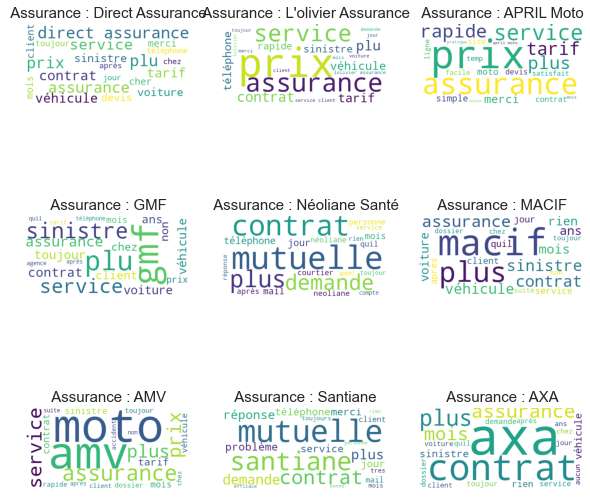

In [298]:
display_wordcloud("WordCloud des 9 assurances avec le plus d'avis",9)

# Analyse de sentiments

In [299]:
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
analyzer_fr = SentimentIntensityAnalyzer()
  
    
data['scores'] = data['Comment'].apply(lambda x: analyzer_fr.polarity_scores(x))

###test
datatest['scores'] = datatest['Comment'].apply(lambda x: analyzer_fr.polarity_scores(x))


In [300]:
### sentiment_vader

data['compound'] = data['scores'].apply(lambda x: x['compound'])
data['sentiment_vader']=''
data.loc[data.compound>0,'sentiment_vader']='Positive_vader'
data.loc[data.compound==0,'sentiment_vader']='Neutral_vader'
data.loc[data.compound<0,'sentiment_vader']='Negative_vader'



###test 
datatest['compound'] = datatest['scores'].apply(lambda x: x['compound'])
datatest['sentiment_vader']=''
datatest.loc[datatest.compound>0,'sentiment_vader']='Positive_vader'
datatest.loc[datatest.compound==0,'sentiment_vader']='Neutral_vader'
datatest.loc[datatest.compound<0,'sentiment_vader']='Negative_vader'

In [301]:
senti_list = []
for i in data["Comment"]:
    vs = tb(i).sentiment[0]
    if (vs > 0):
        senti_list.append('Positive')
    elif (vs < 0):
        senti_list.append('Negative')
    else:
        senti_list.append('Neutral')   
        
data["sentiment"]=senti_list

In [302]:
###test
senti_list = []
for i in datatest["Comment"]:
    vs = tb(i).sentiment[0]
    if (vs > 0):
        senti_list.append('Positive')
    elif (vs < 0):
        senti_list.append('Negative')
    else:
        senti_list.append('Neutral')   
        
datatest["sentiment"]=senti_list

In [303]:
datatest[datatest.sentiment_vader!=datatest.sentiment]

auteur  \
0           lognos-d-139728   
1           paugam-l-139727   
2         rozgonyi-o-139704   
3      saad-hellal-h-139697   
4            damis-s-139693   
...                     ...   
10327      mamybouly-129360   
10328           tarti-88637   
10329         victor-109599   
10330           lkio-110907   
10331         padpad-105625   

                                                    avis             assureur  \
0      satisfait des tarif et rapide jattends de voir...  L'olivier Assurance   
1      bon service service réactif tout en ligne prat...  L'olivier Assurance   
2      l’assurance olivier est une très bonne assuran...  L'olivier Assurance   
3      je suis satisfait de lolivier assurances pas t...  L'olivier Assurance   
4      le prix est attractif par rapport à ma situati...  L'olivier Assurance   
...                                                  ...                  ...   
10327  bonjour jai une mauvaise expérience avec la so...                  Sma   
10328  entreprise très impactée par le covid secteur ...              Allianz   
10329  suite a un cambriolage le je suis toujours dan...              Allianz   
10330  bonjour\r\n\r\nje constate quentre le moment d...             Generali   
10331  longtemps je nai eu besoin de rien et me suis ...                  AXA   

                           produit  Jour  Mois  Annee  mois_siniste  \
0                             auto    16    11   2021            11   
1                             auto    16    11   2021            11   
2                             auto    16    11   2021            11   
3                             auto    16    11   2021            11   
4                             auto    15    11   2021            11   
...                            ...   ...   ...    ...           ...   
10327           garantie-decennale    24     8   2021             8   
10328  assurances-professionnelles    18     5   2021             5   
10329  assurances-professionnelles     8     4   2021             4   
10330  assurances-professionnelles    19     4   2021             4   
10331  assurances-professionnelles     5     3   2021             3   

       annee_siniste                                           Word_Tok  ...  \
0               2021  [satisfait, des, tarif, et, rapide, jattends, ...  ...   
1               2021  [bon, service, service, réactif, tout, en, lig...  ...   
2               2021  [l, assurance, olivier, est, une, très, bonne,...  ...   
3               2021  [je, suis, satisfait, de, lolivier, assurances...  ...   
4               2021  [le, prix, est, attractif, par, rapport, à, ma...  ...   
...              ...                                                ...  ...   
10327           2021  [bonjour, jai, une, mauvaise, expérience, avec...  ...   
10328           2021  [entreprise, très, impactée, par, le, covid, s...  ...   
10329           2021  [suite, a, un, cambriolage, le, je, suis, touj...  ...   
10330           2021  [bonjour, je, constate, quentre, le, moment, d...  ...   
10331           2021  [longtemps, je, nai, eu, besoin, de, rien, et,...  ...   

                                                avis_tok word_count  \
0      [satisfait,, tarif,, rapide,, jattends,, temp,...         14   
1      [service,, service,, réactif,, ligne,, pratiqu...         11   
2      [assurance,, olivier,, bonne,, assurance,, que...          8   
3      [satisfait,, lolivier,, cher,, service,, clien...         12   
4      [prix,, attractif,, rapport,, situation,, form...         12   
...                                                  ...        ...   
10327  [mauvaise,, socobat,, btp,, créé,, sma,, jouer...        201   
10328  [impactée,, covid,, secteur,, perte,, ca,, all...         43   
10329  [suite,, toujours,, lattente,, décisions,, jac...         14   
10330  [constate,, quentre,, moment,, demande,, verse...        148   
10331  [longtemps,, nai,, besoin,, rien,, contenté,, ...         15   

       c

In [304]:
fig = px.histogram(data, x="sentiment_vader",color="sentiment_vader")
fig.update_layout(
    title_text='Sentiment of reviews', # title of plot
    xaxis_title_text='Sentiment', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
fig.show()

In [305]:
Number_sentiment= data.groupby(["sentiment_vader"])["auteur"].count().reset_index().reset_index(drop=True)

fig = px.pie(Number_sentiment, values=Number_sentiment['auteur'], 
             names=Number_sentiment['sentiment_vader'], color="sentiment_vader")
fig.show()


# Apprentissage non supervisé

In [306]:
from sklearn.feature_extraction.text import TfidfTransformer 
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus3)
(X.shape)
#vectorizer.get_feature_names()
#print(X.toarray())

(56, 43119)

In [307]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(X)

TfidfTransformer()

In [308]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"]) 
df_idf.sort_values(by=['idf_weights'])

idf_weights
assurance        1.017700
chez             1.017700
dune             1.035718
plus             1.035718
dossier          1.035718
...                   ...
fuirlibérale     4.349904
fuirlitige       4.349904
fuirlundi        4.349904
fuirjutilise     4.349904
œuvres           4.349904

[43119 rows x 1 columns]

In [309]:
# count matrix 
count_vector=vectorizer.transform(corpus3) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [310]:
feature_names = vectorizer.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)

tfidf
direct         0.390744
assurance      0.378761
prix           0.328903
service        0.255430
plus           0.218839
...                 ...
fuirraison     0.000000
fuirprélevé    0.000000
fuirproscrire  0.000000
fuirproblèmes  0.000000
œuvres         0.000000

[43119 rows x 1 columns]

In [327]:
#wordcloud 

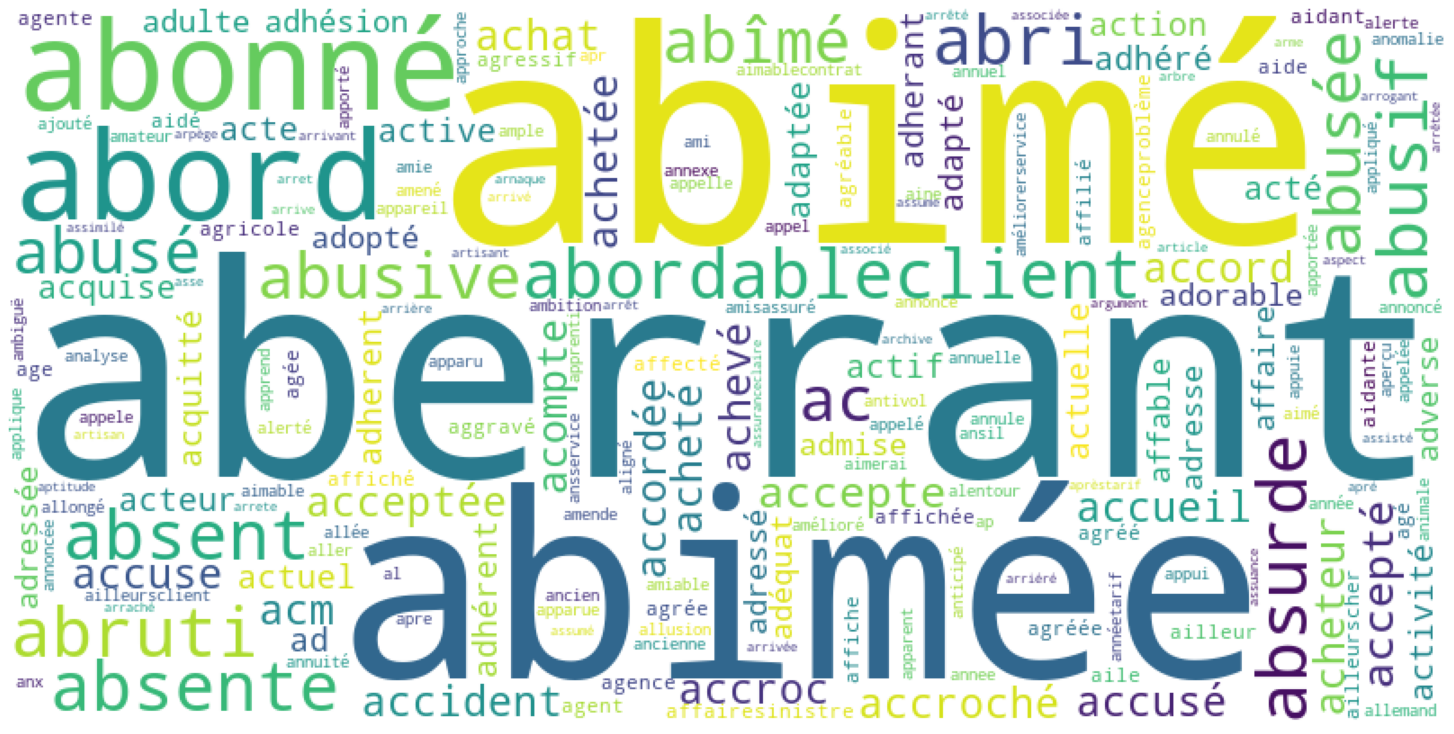

In [311]:
for_wordcloud = vectorizer.get_feature_names()
for_wordcloud = for_wordcloud
for_wordcloud_str = ' '.join(for_wordcloud)

wordcloud = WordCloud(width=800, height=400, background_color ='white',
                      min_font_size = 7).generate(for_wordcloud_str)

plt.figure(figsize=(20, 10), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
 
plt.show()

In [312]:
# try using 10 dimensions
n_comp = 10
lsa_tfidf = TruncatedSVD(n_components=n_comp)
lsa_cv = TruncatedSVD(n_components=n_comp)
nmf_tfidf = NMF(n_components=n_comp)
nmf_cv = NMF(n_components=n_comp)

lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)
lsa_cv_data = lsa_cv.fit_transform(cv_data)
nmf_tfidf_data = nmf_tfidf.fit_transform(tfidf_data)
nmf_cv_data = nmf_cv.fit_transform(cv_data)

In [313]:
# initialize standardscaler
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()

# transform my reducer data using standardscaler
lsa_tfidf_data_sclaed = SS.fit_transform(lsa_tfidf_data)
lsa_cv_data_sclaed = SS.fit_transform(lsa_cv_data)
nmf_tfidf_data_scaled = SS.fit_transform(nmf_tfidf_data)
nmf_cv_data_scaled = SS.fit_transform(nmf_cv_data)

In [314]:
# initialize standardscaler
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()

# transform my reducer data using standardscaler
lsa_tfidf_data_sclaed = SS.fit_transform(lsa_tfidf_data)
lsa_cv_data_sclaed = SS.fit_transform(lsa_cv_data)
nmf_tfidf_data_scaled = SS.fit_transform(nmf_tfidf_data)
nmf_cv_data_scaled = SS.fit_transform(nmf_cv_data)

In [315]:
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

In [316]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

#### Stemmer

In [317]:
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

In [318]:
liste=[]
for i in data['avis_tok']:
    liste2=[]
    for word in i:
        #word=stemmer.stem(word)
        liste2.append(word)
    liste.append(' '.join(liste2))
data['Stremmer']=liste


In [319]:
liste[0]

'meilleurs, prix, solutions, écoute, rapidité, compagnie, prix, attractif, services, qualité, rapidité'

In [320]:
data['avis'][0]

'meilleurs assurances prix solutions écoute rapidité et je recommande cette compagnie pour vous \r\ndes prix attractif et services de qualité et rapidité '

#### Vectorisation

In [321]:
tfidconvert=TfidfVectorizer(analyzer='word',ngram_range=(1, 1)).fit(liste)

In [322]:
print(len(tfidconvert.vocabulary_))
#X_transformed=tfidconvert.transform(liste)

26097


In [323]:
sorted(tfidconvert.vocabulary_.items(), key=lambda t: t[1],reverse=False)

#tfidconvert.vocabulary_

[('000e', 0),
 ('000euros', 1),
 ('000km', 2),
 ('002et', 3),
 ('00h', 4),
 ('00h00', 5),
 ('01er', 6),
 ('01h', 7),
 ('01juin', 8),
 ('02h00', 9),
 ('039710n', 10),
 ('048ct', 11),
 ('04nov', 12),
 ('061319qui', 13),
 ('06272avis', 14),
 ('071120je', 15),
 ('07h', 16),
 ('080en', 17),
 ('080euro', 18),
 ('088365x08', 19),
 ('08h', 20),
 ('08h00', 21),
 ('09h', 22),
 ('0cliente', 23),
 ('0fuyez', 24),
 ('0h', 25),
 ('0j', 26),
 ('0km', 27),
 ('0kmh', 28),
 ('0livier', 29),
 ('0m', 30),
 ('0n', 31),
 ('0que', 32),
 ('10000e', 33),
 ('10000kms', 34),
 ('1000cc', 35),
 ('1000e', 36),
 ('1000euro', 37),
 ('1000euros', 38),
 ('1000kms', 39),
 ('1001le', 40),
 ('100cv', 41),
 ('100des', 42),
 ('100e', 43),
 ('100euro', 44),
 ('100euros', 45),
 ('100km', 46),
 ('100pour', 47),
 ('100santé', 48),
 ('1010une', 49),
 ('10117la', 50),
 ('105ch', 51),
 ('1080an', 52),
 ('1090e', 53),
 ('10a', 54),
 ('10aine', 55),
 ('10aipp', 56),
 ('10années', 57),
 ('10ans', 58),
 ('10aucune', 59),
 ('10e', 60),

In [324]:
'00'.isdigit()

True

#### Kmeans Clustering

In [325]:
modelkmeans=KMeans(n_clusters=2,n_init=100,init='k-means++')
#modelkmeans.fit(X_transformed)

In [326]:
datatest

auteur  \
0           lognos-d-139728   
1           paugam-l-139727   
2         rozgonyi-o-139704   
3      saad-hellal-h-139697   
4            damis-s-139693   
...                     ...   
10327      mamybouly-129360   
10328           tarti-88637   
10329         victor-109599   
10330           lkio-110907   
10331         padpad-105625   

                                                    avis             assureur  \
0      satisfait des tarif et rapide jattends de voir...  L'olivier Assurance   
1      bon service service réactif tout en ligne prat...  L'olivier Assurance   
2      l’assurance olivier est une très bonne assuran...  L'olivier Assurance   
3      je suis satisfait de lolivier assurances pas t...  L'olivier Assurance   
4      le prix est attractif par rapport à ma situati...  L'olivier Assurance   
...                                                  ...                  ...   
10327  bonjour jai une mauvaise expérience avec la so...                  Sma   
10328  entreprise très impactée par le covid secteur ...              Allianz   
10329  suite a un cambriolage le je suis toujours dan...              Allianz   
10330  bonjour\r\n\r\nje constate quentre le moment d...             Generali   
10331  longtemps je nai eu besoin de rien et me suis ...                  AXA   

                           produit  Jour  Mois  Annee  mois_siniste  \
0                             auto    16    11   2021            11   
1                             auto    16    11   2021            11   
2                             auto    16    11   2021            11   
3                             auto    16    11   2021            11   
4                             auto    15    11   2021            11   
...                            ...   ...   ...    ...           ...   
10327           garantie-decennale    24     8   2021             8   
10328  assurances-professionnelles    18     5   2021             5   
10329  assurances-professionnelles     8     4   2021             4   
10330  assurances-professionnelles    19     4   2021             4   
10331  assurances-professionnelles     5     3   2021             3   

       annee_siniste                                           Word_Tok  ...  \
0               2021  [satisfait, des, tarif, et, rapide, jattends, ...  ...   
1               2021  [bon, service, service, réactif, tout, en, lig...  ...   
2               2021  [l, assurance, olivier, est, une, très, bonne,...  ...   
3               2021  [je, suis, satisfait, de, lolivier, assurances...  ...   
4               2021  [le, prix, est, attractif, par, rapport, à, ma...  ...   
...              ...                                                ...  ...   
10327           2021  [bonjour, jai, une, mauvaise, expérience, avec...  ...   
10328           2021  [entreprise, très, impactée, par, le, covid, s...  ...   
10329           2021  [suite, a, un, cambriolage, le, je, suis, touj...  ...   
10330           2021  [bonjour, je, constate, quentre, le, moment, d...  ...   
10331           2021  [longtemps, je, nai, eu, besoin, de, rien, et,...  ...   

                                                avis_tok word_count  \
0      [satisfait,, tarif,, rapide,, jattends,, temp,...         14   
1      [service,, service,, réactif,, ligne,, pratiqu...         11   
2      [assurance,, olivier,, bonne,, assurance,, que...          8   
3      [satisfait,, lolivier,, cher,, service,, clien...         12   
4      [prix,, attractif,, rapport,, situation,, form...         12   
...                                                  ...        ...   
10327  [mauvaise,, socobat,, btp,, créé,, sma,, jouer...        201   
10328  [impactée,, covid,, secteur,, perte,, ca,, all...         43   
10329  [suite,, toujours,, lattente,, décisions,, jac...         14   
10330  [constate,, quentre,, moment,, demande,, verse...        148   
10331  [longtemps,, nai,, besoin,, rien,, contenté,, ...         15   

       c

#### LDA

In [256]:
## topic modeling


     |████████████████████████████████| 24.0 MB 16.2 MB/s eta 0:00:01


In [328]:
# Importer Gensim
import gensim
from gensim import corpora

In [330]:
# Creer le dictionnaire de termes de nos commentaires
dictionary = corpora.Dictionary(data.avis_tok)

#Convertir la liste de commentaire en Matrice de termes  
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data.avis_tok]

In [331]:
#Création de modèle
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [351]:
print(ldamodel.print_topics())

[(0, '0.015*"plus," + 0.013*"mois," + 0.013*"contrat," + 0.010*"toujours," + 0.010*"mutuelle," + 0.009*"demande," + 0.008*"dossier," + 0.007*"réponse," + 0.007*"après," + 0.006*"service,"'), (1, '0.018*"plus," + 0.016*"assurance," + 0.014*"sinistre," + 0.011*"ans," + 0.011*"véhicule," + 0.011*"chez," + 0.008*"voiture," + 0.007*"mois," + 0.006*"charge," + 0.006*"non,"'), (2, '0.046*"prix," + 0.035*"service," + 0.031*"satisfait," + 0.027*"assurance," + 0.017*"rapide," + 0.013*"simple," + 0.011*"client," + 0.010*"tarifs," + 0.010*"site," + 0.010*"merci,"')]


# Apprentissage Supervisé

In [67]:
liste_categorique=["assureur","produit","sentiment_vader",'sentiment']    


liste=[]
for i in liste_categorique:
    onehotencoder_1 = OneHotEncoder(handle_unknown = 'ignore').fit(np.array(data[i]).reshape(-1, 1))
    data[onehotencoder_1.categories_[0]] = onehotencoder_1.transform(np.array(data[i]).reshape(-1, 1)).toarray().astype(int)
    data=data.drop([i],axis=1)
    


In [68]:
liste=[]
for i in liste_categorique:
    onehotencoder_1 = OneHotEncoder(handle_unknown = 'ignore').fit(np.array(datatest[i]).reshape(-1, 1))
    datatest[onehotencoder_1.categories_[0]] = onehotencoder_1.transform(np.array(datatest[i]).reshape(-1, 1)).toarray().astype(int)
    datatest=datatest.drop([i],axis=1)
    

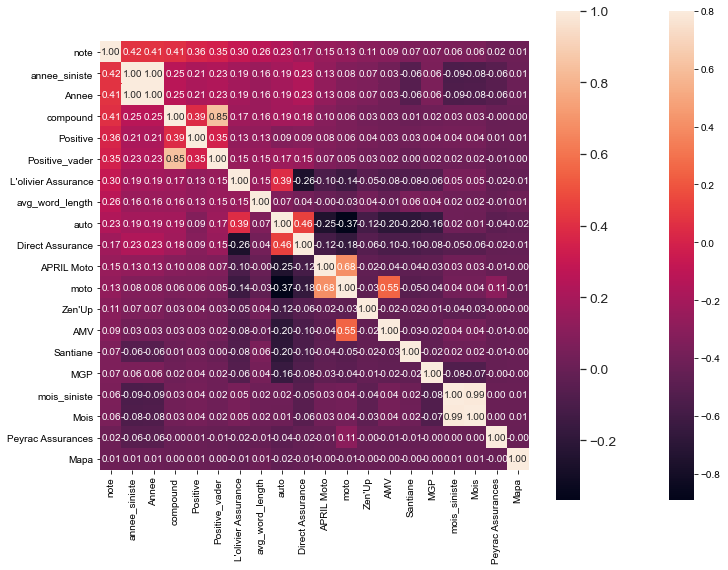

In [69]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

#saleprice correlation matrix
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'note')['note'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [245]:
y = data['note']
X = data.drop(['note','auteur','avis',"Word_Tok","Comment",'avis_tok','scores','Stremmer'],axis=1)


In [248]:
X

assureur     produit  Jour  Mois  Annee  mois_siniste  \
0          Direct Assurance        auto     6     9   2021             9   
1          Direct Assurance        auto     3     5   2021             5   
2          Direct Assurance        auto    21     3   2021             3   
3       L'olivier Assurance        auto    10     6   2021             6   
4                    Matmut        auto    29     1   2017             1   
...                     ...         ...   ...   ...    ...           ...   
24100  Mutuelle des Motards        moto    22     3   2021             3   
24101               Allianz  habitation     6    12   2019            12   
24102     Cegema Assurances       sante    14     4   2021             4   
24103                   GMF        auto    11     7   2019             7   
24104                   AMV        moto    19     1   2017             1   

       annee_siniste  word_count  char_count  sentence_count  avg_word_length  \
0               2021          11          81               1         7.363636   
1               2021          14          95               1         6.785714   
2               2021          13          92               1         7.076923   
3               2021           9          63               1         7.000000   
4               2017          53         318               1         6.000000   
...              ...         ...         ...             ...              ...   
24100           2021          26         164               1         6.307692   
24101           2019          11          72               1         6.545455   
24102           2021         117         708               1         6.051282   
24103           2019          34         181               1         5.323529   
24104           2017          29         154               1         5.310345   

       avg_sentence_lenght  compound sentiment_vader sentiment  
0                     11.0    0.8225  Positive_vader  Positive  
1                     14.0    0.1531  Positive_vader  Positive  
2                     13.0    0.7506  Positive_vader  Positive  
3                      9.0    0.7906  Positive_vader  Positive  
4                     53.0    0.7064  Positive_vader  Negative  
...                    ...       ...             ...       ...  
24100                 26.0   -0.2263  Negative_vader  Positive  
24101                 11.0    0.3156  Positive_vader  Negative  
24102                117.0    0.9351  Positive_vader  Positive  
24103                 34.0    0.5615  Positive_vader  Positive  
24104                 29.0    0.6369  Positive_vader  Positive  

[24105 rows x 15 columns]

### Regression

In [246]:
splits = np.round(np.linspace(0.3,0.5,3),2)
res = pd.DataFrame({"Methode" : [],
                    "Modèle" : [],
                    "Paramètres" : [],
                    "RMSE_train" : [],
                    "RMSE_test" : [],
                    "R2_train" : [],
                    "R2_test" : []
                   })
from sklearn.metrics import mean_squared_error

In [247]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import random

depth = np.round(np.linspace(1, 10, 10))

for s in splits :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, shuffle = True, random_state=1)
    param_done = []
    for _ in range (depth.size//2) :
        d = depth[random.randint(0,depth.size - 1)]
        while d in param_done :
            d = depth[random.randint(0,depth.size - 1)]
        param_done.append(d)  
        dtr = DecisionTreeRegressor(max_depth = d, random_state=1).fit(X,y)
        dtr_pred_train = dtr.predict(X_train)
        dtr_pred_train=np.round(dtr_pred_train,0)
        
        dtr_pred_test = dtr.predict(X_test)
        dtr_pred_test=np.round(dtr_pred_test,0)
        
        
        RMSE_train = mean_squared_error(y_train, dtr_pred_train)
        RMSE_test=mean_squared_error(y_test, dtr_pred_test)
        
        score_train = np.round(dtr.score(X_train,y_train),6)
        score_test = np.round(dtr.score(X_test,y_test),6)
        
        res=res.append({"Methode" : "DecisionTreeRegressor",
                    "Modèle" : dtr,
                    "Paramètres" : {"split" : s,"depth" : d},
                    "RMSE_train" : RMSE_train,
                    "RMSE_test" : RMSE_test,
                    "R2_train" : score_train,
                    "R2_test" : score_test
                   }, ignore_index=True )

ValueError: could not convert string to float: 'Direct Assurance'

In [244]:
from sklearn.ensemble import BaggingRegressor

n_estimators= np.round(np.linspace(10, 60, 6))

for s in splits :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, shuffle = True, random_state=1)
    param_done = []
    for _ in range (n_estimators.size//2) :
        n = n_estimators[random.randint(0,n_estimators.size - 1)]
        while n in param_done :
            n = n_estimators[random.randint(0,n_estimators.size - 1)]
        param_done.append(n)  
        br = BaggingRegressor(n_estimators=int(n)).fit(X,y)
        
        br_pred_train = br.predict(X_train)
        br_pred_train=np.round(br_pred_train,0)
        
        
        br_pred_test = br.predict(X_test)
        br_pred_test=np.round(br_pred_test,0)
        
        
        RMSE_train = mean_squared_error(y_train, br_pred_train)**0.5
        RMSE_test=mean_squared_error(y_test, br_pred_test)**0.5
        
        score_train = np.round(br.score(X_train,y_train),6)
        score_test = np.round(br.score(X_test,y_test),6)   
        
        res=res.append({"Methode" : "BaggingRegressor",
                    "Modèle" : br,
                    "Paramètres" : {"split" : s,"n_estimators" : n},
                    "RMSE_train" : RMSE_train,
                    "RMSE_test" : RMSE_test,
                    "R2_train" : score_train,
                    "R2_test" : score_test  
                   }, ignore_index=True )

ValueError: Found input variables with inconsistent numbers of samples: [56, 24105]

In [243]:
from sklearn.ensemble import GradientBoostingRegressor

n_estimators= np.round(np.linspace(40, 120, 5))  
alphas = np.round(np.linspace(0, 2,100),2)
l1_ratios = np.round(np.linspace(0,1,101),2)

for s in splits :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, shuffle = True, random_state=1)
    param_done = []
    for _ in range ((alphas.size * l1_ratios.size * n_estimators.size)//5000) :
        n = n_estimators[random.randint(0,n_estimators.size - 1)]        
        a = alphas[random.randint(0,alphas.size - 1)]
        l = l1_ratios[random.randint(0,l1_ratios.size - 1)]
        while (a,l,n) in param_done :
            a = alphas[random.randint(0,alphas.size - 1)]
            l = l1_ratios[random.randint(0,l1_ratios.size - 1)]
            n = n_estimators[random.randint(0,n_estimators.size - 1)]
        param_done.append((a,l,n))  
        gbr = GradientBoostingRegressor(n_estimators=int(n)).fit(X,y)
        
        gbr_pred_train = gbr.predict(X_train)
        gbr_pred_train=np.round(gbr_pred_train,0)
        
        
        gbr_pred_test = gbr.predict(X_test)
        gbr_pred_test=np.round(gbr_pred_test,0)
        
        RMSE_train = mean_squared_error(y_train, gbr_pred_train)**0.5
        RMSE_test=mean_squared_error(y_test, gbr_pred_test)**0.5
        
        score_train = np.round(gbr.score(X_train,y_train),6)
        score_test = np.round(gbr.score(X_test,y_test),6) 
        
        res=res.append({"Methode" : "GradientBoostingRegressor",
                    "Modèle" : gbr,
                    "Paramètres" : {"split" : s,"alpha" : a,"l1_ratios" : l,"n_estimators" : n},
                    "RMSE_train" : RMSE_train,
                    "RMSE_test" : RMSE_test,
                    "R2_train" : score_train,
                    "R2_test" : score_test  
                   }, ignore_index=True )

ValueError: Found input variables with inconsistent numbers of samples: [56, 24105]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

n_estimators= np.round(np.linspace(40, 120, 5))  
depth = np.round(np.linspace(1, 10, 10))

for s in splits :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, shuffle = True, random_state=1)
    param_done = []
    for _ in range ((depth.size * n_estimators.size)//5) :
        n = n_estimators[random.randint(0,n_estimators.size - 1)]        
        d = depth[random.randint(0,depth.size - 1)]
        while (d,n) in param_done :
            d = depth[random.randint(0,depth.size - 1)]
            n = n_estimators[random.randint(0,n_estimators.size - 1)]
        param_done.append((d,n))  
        rfr = RandomForestRegressor(n_estimators=int(n),max_depth=d).fit(X,y)
        
        rfr_pred_train = rfr.predict(X_train)
        rfr_pred_train=np.round(rfr_pred_train,0)
        
        
        rfr_pred_test = rfr.predict(X_test)
        rfr_pred_test=np.round(rfr_pred_test,0)
        
        
        RMSE_train = mean_squared_error(y_train, rfr_pred_train)**0.5
        RMSE_test=mean_squared_error(y_test, rfr_pred_test)**0.5
        
        
        score_train = np.round(rfr.score(X_train,y_train),6)
        score_test = np.round(rfr.score(X_test,y_test),6)        
        res=res.append({"Methode" : "RandomForestRegressor",
                    "Modèle" : rfr,
                    "Paramètres" : {"split" : s,"max_depth" : d,"n_estimators" : n},
                    "RMSE_train" : RMSE_train,
                    "RMSE_test" : RMSE_test,
                    "R2_train" : score_train,
                    "R2_test" : score_test  
                   }, ignore_index=True )

In [ ]:
res.sort_values(by="RMSE_test",ascending=True).reset_index(drop=True)

In [ ]:
final_model = BaggingRegressor(n_estimators = 50).fit(X_train,y_train)

In [ ]:
br_pred_train = final_model.predict(X_train)
br_pred_train=np.round(br_pred_train,0)
        
RMSE_train = mean_squared_error(y_train, br_pred_train)**0.5
        
score_train = np.round(br.score(X_train,y_train),6)


In [ ]:
RMSE_train

In [ ]:
test_predict = final_model.predict(X_test)

In [ ]:
score_train = np.round(br.score(X_test,y_test),6)
print(score_train)

In [ ]:
## Test
datatest = datatest.drop(['auteur','avis',"Word_Tok","Comment",'avis_tok','scores'],axis=1)


In [ ]:
br_pred_train = final_model.predict(datatest)

In [ ]:
br_pred_train=np.round(br_pred_train,0)

In [ ]:
br_pred_train

### Classification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=1)


In [ ]:
X_test

##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

logreg_pred_ = logreg.predict(X_test)
#print('Accuracy of Logistic regression classifier on training set: {:.2f}' .format(logreg.score(X_train, y_train)))
#print('Accuracy of Logistic regression classifier on test set: {:.2f}'
#     .format(logreg.score(X_test, y_test)))

In [ ]:
logreg.score(X_train, y_train)

mean_squared_error(y_test, logreg_pred_)**0.5

##### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))


print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
clf_pred_ = clf.predict(X_test)


In [ ]:
print(mean_squared_error(y_test, clf_pred_)**0.5 )


##### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X, y)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

In [ ]:
knn_pred_ = knn.predict(X_test)
print(mean_squared_error(y_test, knn_pred_)**0.5 )

##### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

In [ ]:
lda_pred_ = lda.predict(X_test)
print(mean_squared_error(y_test, lda_pred_)**0.5 )

##### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))


In [ ]:
gnb_pred_ = gnb.predict(X_test)
print(mean_squared_error(y_test, gnb_pred_)**0.5 )

##### SVC

In [ ]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

In [ ]:
svm_pred_ = svm.predict(X_test)
print(mean_squared_error(y_test, svm_pred_)**0.5 )